# Image Pixelization / De-Pixelization Demo with AREA Filter

This notebook demonstrates how to create a pixelated animation from an original image and then attempt to reconstruct an image from these pixelated blocks.\
The pixelation effect is achieved using a `area` neighbor filter during downsampling and `nearest` neighbor filter during upsampling of a moving window.

This will be the same as `mosaic-nearest.ipynb`.\
We will see that the resulting reconstructed image is not very readable, and then try to improve the output.

## 1. Load Original Image

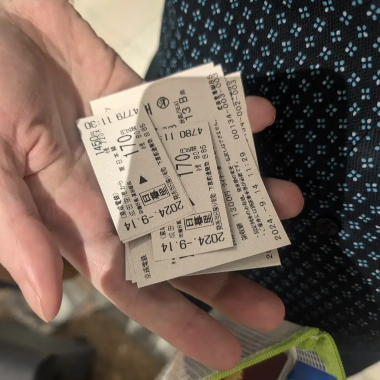

In [1]:
import PIL.Image as Image
import torchvision.transforms.functional as TF

original = TF.to_tensor(Image.open('template.png').convert('RGBA')).unsqueeze_(0)

H, W = original.size()[-2:]

TF.to_pil_image(original[0])

## 2. Generate a Motion for the Pixelation

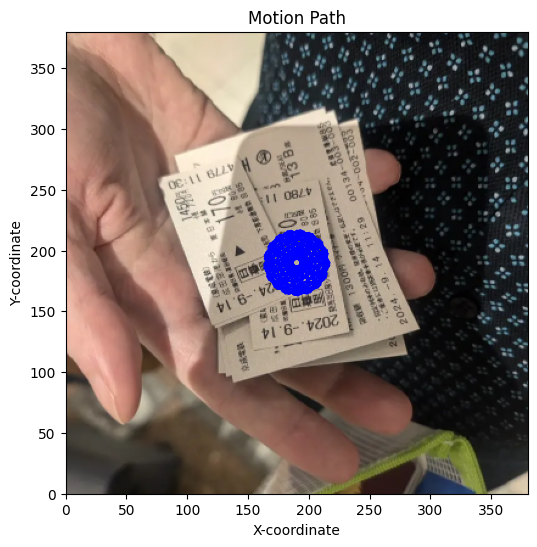

In [2]:
import math

CHUNK_SIZE = 16
NUM_FRAMES = 250
AREA_SIZE = min(W, H) // 2 // CHUNK_SIZE * CHUNK_SIZE

# generate the motion of the pixelation
motion = []
for i in range(NUM_FRAMES):
    motion.append((
        W / 2 + math.cos(i / NUM_FRAMES * math.pi * 2) * AREA_SIZE / CHUNK_SIZE + math.cos(i) * CHUNK_SIZE,
        H / 2 + math.sin(i / NUM_FRAMES * math.pi * 2) * AREA_SIZE / CHUNK_SIZE + math.sin(i) * CHUNK_SIZE
    ))

# display the path
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))
plt.imshow(TF.to_pil_image(TF.vflip(original[0])))
plt.plot(
    [m[0] for m in motion],
    [m[1] for m in motion],
    linestyle='-',
    color='b'
)
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")
plt.title("Motion Path")
plt.xlim(0, W)
plt.ylim(0, H)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

## 3. Pixelate

In [3]:
import torch
import torch.nn.functional as F

frames_pixelated = torch.zeros((NUM_FRAMES, 4, H, W))
frames_pixelated[:] = original

for i, (shift_x, shift_y) in enumerate(motion):
    x_start = round(shift_x - AREA_SIZE / 2)
    x_end = x_start + AREA_SIZE
    y_start = round(shift_y - AREA_SIZE / 2)
    y_end = y_start + AREA_SIZE
    frames_pixelated[
        i:i+1,
        ...,
        y_start:y_end,
        x_start:x_end
    ] = F.interpolate(
        F.interpolate(
            original[
                ...,
                y_start:y_end,
                x_start:x_end
            ],
            size=(AREA_SIZE // CHUNK_SIZE, AREA_SIZE // CHUNK_SIZE),
            mode='area' # use AREA-FILTER
        ),
        size=(AREA_SIZE, AREA_SIZE),
        mode='nearest'
    )

def display_frames(title, frames):
    fig, ax = plt.subplots()
    ims = []
    for frame in frames:
        pil_image = TF.to_pil_image(TF.vflip(frame))
        im_artist = ax.imshow(pil_image, animated=True)
        ims.append([im_artist])

    import matplotlib.animation as animation
    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)

    plt.xlabel("X-coordinate")
    plt.ylabel("Y-coordinate")
    plt.title(title)
    plt.xlim(0, W)
    plt.ylim(0, H)
    plt.gca().set_aspect('equal', adjustable='box')

    res =  ani.to_html5_video()
    plt.close()

    return res

from IPython.display import HTML
HTML(display_frames("Pixelated", frames_pixelated))

## 4. Collect all Pixels and put them at their Global Position 

this is of course just a best case secenario, extracting the motion would be very easy.\
in this case we will just reuse the motion, we used to generate the pixelation.

In [4]:
frame_pixels = torch.zeros((NUM_FRAMES, 4, H, W))

for i, (shift_x, shift_y) in enumerate(motion):
    x_start = round(shift_x - AREA_SIZE / 2)
    x_end = x_start + AREA_SIZE
    y_start = round(shift_y - AREA_SIZE / 2)
    y_end = y_start + AREA_SIZE
    frame_pixels[
        i:i+1, ...,
        y_start:y_end:CHUNK_SIZE,
        x_start:x_end:CHUNK_SIZE
    ] = F.interpolate(frames_pixelated[
        i:i+1,
        ...,
        y_start:y_end,
        x_start:x_end
    ], size=(AREA_SIZE // CHUNK_SIZE, AREA_SIZE // CHUNK_SIZE), mode='area')

HTML(display_frames("Pixels", frame_pixels))

## 5. Accumulate Pixels into Single Frame

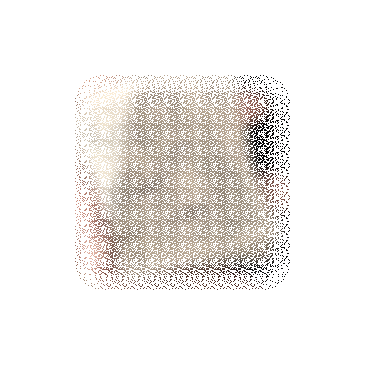

In [5]:
frame_accumulated = frame_pixels.sum(0, keepdim=True)
frame_accumulated = frame_accumulated / frame_accumulated[:,-1:]
frame_accumulated[~torch.isfinite(frame_accumulated)] = 0.0

TF.to_pil_image(frame_accumulated[0])

## 6. Grow the Pixels

this is just to make the result more readable

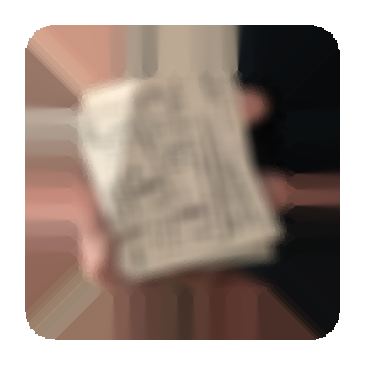

In [6]:
frame_grown = frame_accumulated.clone()

for _ in range(50):
  c = frame_grown[:, -1:] == 0
  x = F.avg_pool2d(frame_grown, 3, 1, 1, False, False, 1)
  frame_grown += c.float() * x

frame_grown = frame_grown / frame_grown[:, -1:]
frame_grown[~torch.isfinite(frame_grown)] = 0.0

TF.to_pil_image(frame_grown[0])

## 7. Restore the Original Image with Gradient-Decent

just gradient descent the `frame_trained` (`frame_grown` as basis) to output `frame_accumulated` after a a `avg_pool2d` (~ `area` filter).

(could use deconvolution .. to calculate the output faster, since we know the PSF)

use device xpu
0.00% loss 0.0017233098624274135
5.00% loss 0.0003811748174484819
10.00% loss 0.00013332416710909456
15.00% loss 6.239472713787109e-05
20.00% loss 3.9178783481474966e-05
25.00% loss 2.8996435503358953e-05
30.00% loss 2.378798308200203e-05
35.00% loss 2.0362787836347707e-05
40.00% loss 1.8045722754322924e-05
45.00% loss 1.6248110114247538e-05
50.00% loss 1.4865978300804272e-05
55.00% loss 1.3854772987542674e-05
60.00% loss 1.3131879313732497e-05
65.00% loss 1.25244487207965e-05
70.00% loss 1.1617347809078638e-05
75.00% loss 1.1043290214729495e-05
80.00% loss 1.0946985639748164e-05
85.00% loss 1.027162215905264e-05
90.00% loss 9.949454579327721e-06
95.00% loss 9.796838639886118e-06


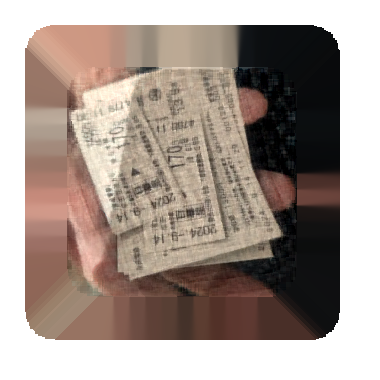

In [8]:
import torch.nn as nn
import torch.optim as optim

device = 'cpu'
if torch.xpu.is_available():
    device = 'xpu'
elif torch.cuda.is_available():
    device = 'cuda'
print('use device', device)

frame_grown = frame_grown.to(device)
frame_accumulated = frame_accumulated.to(device)
frame_trained = nn.Parameter(frame_grown.clone(), requires_grad=True)

optimizer = optim.Adam([frame_trained])
mask = (frame_accumulated[:, -1:] != 0).float()
ROUNDS = 2000
for i in range(ROUNDS):
    #frame_trained.data.add_(torch.randn_like(frame_trained).mul_(1/1024))
    filtered = F.avg_pool2d(frame_trained, CHUNK_SIZE, 1)
    filtered = F.pad(filtered, (
        CHUNK_SIZE // 2, H - filtered.size(-2) - CHUNK_SIZE // 2,
        CHUNK_SIZE // 2, W - filtered.size(-1) - CHUNK_SIZE // 2
    ))
    optimizer.zero_grad()
    loss = F.l1_loss(filtered * mask, frame_accumulated * mask)
    loss.backward()
    optimizer.step()
    frame_trained.data.clamp_(0, 1)
    if (i % 100) == 0:
        print(f'{i / ROUNDS * 100:03.2f}%', 'loss', float(loss))

TF.to_pil_image(frame_trained[0])